In [55]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#导入数据
housedata=fetch_california_housing()
#划分测试集和训练集
train_x,test_x,train_y,test_y=train_test_split(housedata.data,housedata.target,test_size=0.3,random_state=42)
print(train_x.shape,train_y.shape)

from sklearn.preprocessing import StandardScaler
#标准化处理
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
test_x=scale.fit_transform(test_x)

train_x.shape,train_y.shape,test_x.shape,test_y.shape

(14448, 8) (14448,)


((14448, 8), (14448,), (6192, 8), (6192,))

In [56]:
# Split dataset
def split_list_n_list(origin_list, n):
    if len(origin_list) % n == 0:
        cnt = len(origin_list) // n
    else:
        cnt = len(origin_list) // n + 1
 
    for i in range(0, n):
        yield origin_list[i*cnt:(i+1)*cnt]

In [57]:
#preparing teacher's datasets
n_teachers=10
teacher_x,teacher_y = [],[]
teacher_datasets = []
teacher_data_loader = []



teacher_x_loder = split_list_n_list(train_x,n_teachers)
teacher_y_loder = split_list_n_list(train_y,n_teachers)

teacher_x.extend(iter(teacher_x_loder))
teacher_y.extend(iter(teacher_y_loder))

for i in range(n_teachers):
    print(i,teacher_x[i].shape,teacher_y[i].shape)


from torch.utils.data import TensorDataset, DataLoader
teacher_datasets.extend(TensorDataset(torch.tensor(teacher_x[u],device=device,dtype=torch.float),
                                       torch.tensor(teacher_y[u],device=device,dtype=torch.float))
                        for u in  range(n_teachers))

teacher_data_loader.extend(DataLoader(teacher_datasets[i],batch_size=32,shuffle=True)
                           for i in range(n_teachers))
# print(teacher_x)


print ('preparing students dataset')
student_x,student_y = [] ,[]
student_datasets= []
 

student_x_loder =  split_list_n_list(test_x,2)
student_y_loder =  split_list_n_list(test_y,2)
student_x.extend(iter(student_x_loder))
student_y.extend(iter(student_y_loder))

for i in range(2):
    print(i,student_x[i].shape,student_y[i].shape)

student_datasets.extend(
                        TensorDataset(torch.tensor(student_x[u],device=device,dtype=torch.float),
                                      torch.tensor(student_y[u],device=device,dtype=torch.float))
                        for u in range(2)
)
# model_valid_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]))
student_train_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]),shuffle=True)
student_test_loader = DataLoader(student_datasets[1], batch_size=len(student_datasets[1]))


0 (1445, 8) (1445,)
1 (1445, 8) (1445,)
2 (1445, 8) (1445,)
3 (1445, 8) (1445,)
4 (1445, 8) (1445,)
5 (1445, 8) (1445,)
6 (1445, 8) (1445,)
7 (1445, 8) (1445,)
8 (1445, 8) (1445,)
9 (1443, 8) (1443,)
preparing students dataset
0 (3096, 8) (3096,)
1 (3096, 8) (3096,)


In [58]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import pyro
from pyro.distributions import Normal
from pyro.distributions import Categorical
from pyro.optim import Adam
from pyro.infer import SVI
from pyro.infer import Trace_ELBO

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


class Linear_BBB(nn.Module):
    """
        Layer of our BNN.
    """
    def __init__(self, input_features, output_features, prior_var=1.):
        """
            Initialization of our layer : our prior is a normal distribution
            centered in 0 and of variance 20.
        """
        # initialize layers
        super().__init__()
        # set input and output dimensions
        self.input_features = input_features
        self.output_features = output_features

        # initialize mu and rho parameters for the weights of the layer
        self.w_mu = nn.Parameter(torch.zeros(output_features, input_features))
        self.w_rho = nn.Parameter(torch.zeros(output_features, input_features))

        #initialize mu and rho parameters for the layer's bias
        self.b_mu =  nn.Parameter(torch.zeros(output_features))
        self.b_rho = nn.Parameter(torch.zeros(output_features))        

        #initialize weight samples (these will be calculated whenever the layer makes a prediction)
        self.w = None
        self.b = None

        # initialize prior distribution for all of the weights and biases
        self.prior = torch.distributions.Normal(0,prior_var)

    def forward(self, input):
        """
          Optimization process
        """
        # sample weights
        w_epsilon = Normal(0,1).sample(self.w_mu.shape).to(device)
        self.w = self.w_mu + torch.log(1+torch.exp(self.w_rho)) * w_epsilon

        # sample bias
        b_epsilon = Normal(0,1).sample(self.b_mu.shape).to(device)
        self.b = self.b_mu + torch.log(1+torch.exp(self.b_rho)) * b_epsilon

        # record log prior by evaluating log pdf of prior at sampled weight and bias
        w_log_prior = self.prior.log_prob(self.w)
        b_log_prior = self.prior.log_prob(self.b)
        self.log_prior = torch.sum(w_log_prior) + torch.sum(b_log_prior)

        # record log variational posterior by evaluating log pdf of normal distribution defined by parameters with respect at the sampled values
        self.w_post = Normal(self.w_mu.data, torch.log(1+torch.exp(self.w_rho)).to(device))
        self.b_post = Normal(self.b_mu.data, torch.log(1+torch.exp(self.b_rho)).to(device))
        self.log_post = self.w_post.log_prob(self.w).sum() + self.b_post.log_prob(self.b).sum()

        return F.linear(input, self.w, self.b)

class MLP_BBB(nn.Module):
    def __init__(self, hidden_units, noise_tol=.1,  prior_var=1.):

        # initialize the network like you would with a standard multilayer perceptron, but using the BBB layer
        super().__init__()
        self.hidden = Linear_BBB(8,hidden_units, prior_var=prior_var)
        self.out = Linear_BBB(hidden_units, 1, prior_var=prior_var)
        self.noise_tol = noise_tol # we will use the noise tolerance to calculate our likelihood

    def forward(self, x):
        # again, this is equivalent to a standard multilayer perceptron
        x = torch.sigmoid(self.hidden(x)).to(device)
        x = self.out(x)
        return x

    def log_prior(self):
        # calculate the log prior over all the layers
        return self.hidden.log_prior + self.out.log_prior

    def log_post(self):
        # calculate the log posterior over all the layers
        return self.hidden.log_post + self.out.log_post

    def sample_elbo(self, input, target, samples):
        # we calculate the negative elbo, which will be our loss function
        #initialize tensors
        outputs = torch.zeros(samples, target.shape[0]).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_posts = torch.zeros(samples).to(device)
        log_likes = torch.zeros(samples).to(device)
        # make predictions and calculate prior, posterior, and likelihood for a given number of samples
        for i in range(samples):
            outputs[i] = self(input).reshape(-1).to(device) # make predictions
            log_priors[i] = self.log_prior() # get log prior
            log_posts[i] = self.log_post() # get log variational posterior
            log_likes[i] = Normal(outputs[i], self.noise_tol).log_prob(target.reshape(-1)).sum() # calculate the log likelihood
        # calculate monte carlo estimate of prior posterior and likelihood
        log_prior = log_priors.mean()
        log_post = log_posts.mean()
        log_like = log_likes.mean()
        # calculate the negative elbo (which is our loss function)
        loss = log_post - log_prior - log_like
        return loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
BNN = MLP_BBB(72, prior_var=1).to(device)
print(BNN)


MLP_BBB(
  (hidden): Linear_BBB()
  (out): Linear_BBB()
)


In [59]:
 
#training configs
num_epochs=3000
batch_size =32
lr =1e-4
#initializing  teachers model
teachers_model = []

for i in range(n_teachers):
    net = BNN
    teachers_model.append(net)
 
teacher_optimizers = [torch.optim.Adam(teachers_model[i].parameters(), lr=lr) for i in range(n_teachers)]


#creating teachers folders
import os
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

for i in  range(n_teachers):
    mkdir_if_missing(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/teacher{i}')

In [60]:
#training teacher models
loss_func=nn.MSELoss()
# loss_all=[[0]*num_epochs]*n_teachers
train_loss_all=[]
for tea_num in range(n_teachers):
    print(f'start training number {tea_num} techer!')
    minloss =float ('inf')
    
    for epoch in range(num_epochs):
        # train_loss = 0
        # train_num=0
        teachers_model[tea_num].train()
        for b_x,b_y in teacher_data_loader[tea_num]:
            teacher_optimizers[tea_num].zero_grad()
            output=teachers_model[tea_num](b_x.to(device))
            loss=loss_func(output,b_y)
            loss.backward()
            teacher_optimizers[tea_num].step()
            
            teacher_optimizers[tea_num].zero_grad()
            loss_houyan = teachers_model[tea_num].sample_elbo(b_x.to(device),b_y.to(device),1)
            loss_houyan.backward()
            teacher_optimizers[tea_num].step()

            # train_loss+=loss.item() * b_x.size(0)
            # train_num += b_x.size(0)
            # loss_tea = train_loss/train_num
            
            if loss< minloss:
                minloss = loss
            # if loss_houyan< minloss:
            #     minloss = loss_houyan
                if os.path.exists(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/teacher{tea_num}/best.pth'):
                    os.remove(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/teacher{tea_num}/best.pth')
                torch.save(teachers_model[tea_num], f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/teacher{tea_num}/best.pth')
            
        
        # loss_all[tea_num][epoch]+=loss
        if epoch%10== 0:
            print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss}', f' loss_houyan:{loss_houyan}')
        train_loss_all.append(loss) 
    print(f'finished training number {tea_num} techer!')

            
            

start training number 0 techer!


/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:0 epoch: 1/3000 loss_tea:4.219130992889404  loss_houyan:9749.5927734375
Number:0 epoch: 11/3000 loss_tea:4.734267711639404  loss_houyan:1237.098388671875
Number:0 epoch: 21/3000 loss_tea:2.553999185562134  loss_houyan:3517.08642578125
Number:0 epoch: 31/3000 loss_tea:30.261249542236328  loss_houyan:1397.785400390625
Number:0 epoch: 41/3000 loss_tea:12.815652847290039  loss_houyan:1647.355224609375
Number:0 epoch: 51/3000 loss_tea:4.116450786590576  loss_houyan:1373.609375
Number:0 epoch: 61/3000 loss_tea:2.6856658458709717  loss_houyan:4535.2646484375
Number:0 epoch: 71/3000 loss_tea:10.946446418762207  loss_houyan:579.8133544921875
Number:0 epoch: 81/3000 loss_tea:5.440420627593994  loss_houyan:292.24688720703125
Number:0 epoch: 91/3000 loss_tea:31.397714614868164  loss_houyan:8300.1240234375
Number:0 epoch: 101/3000 loss_tea:5.5323920249938965  loss_houyan:9303.4697265625
Number:0 epoch: 111/3000 loss_tea:16.030101776123047  loss_houyan:2863.265869140625
Number:0 epoch: 121/30

/home/wangyipeng/anaconda3/envs/ysy/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Number:9 epoch: 1/3000 loss_tea:0.3439459800720215  loss_houyan:331.5208740234375
Number:9 epoch: 11/3000 loss_tea:1.6016401052474976  loss_houyan:314.36407470703125
Number:9 epoch: 21/3000 loss_tea:0.3446124196052551  loss_houyan:300.5630798339844
Number:9 epoch: 31/3000 loss_tea:1.3690714836120605  loss_houyan:307.7868347167969
Number:9 epoch: 41/3000 loss_tea:5.167901515960693  loss_houyan:311.2427062988281
Number:9 epoch: 51/3000 loss_tea:2.284452199935913  loss_houyan:298.1821594238281
Number:9 epoch: 61/3000 loss_tea:1.173291802406311  loss_houyan:318.2344970703125
Number:9 epoch: 71/3000 loss_tea:1.412232518196106  loss_houyan:545.4393920898438
Number:9 epoch: 81/3000 loss_tea:0.11183272302150726  loss_houyan:290.7821960449219
Number:9 epoch: 91/3000 loss_tea:3.2507150173187256  loss_houyan:431.3484802246094
Number:9 epoch: 101/3000 loss_tea:2.0366435050964355  loss_houyan:319.956298828125
Number:9 epoch: 111/3000 loss_tea:0.3022667169570923  loss_houyan:340.861328125
Number:9 e

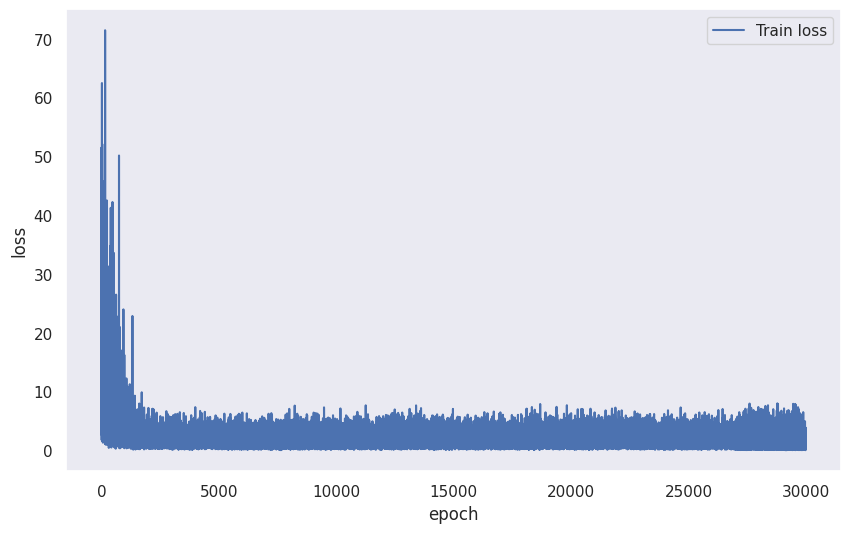

In [61]:
    
plt.figure(figsize=(10,6))
train_loss_all = torch.tensor(train_loss_all, device = 'cpu')
plt.plot(train_loss_all ,label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [62]:
#计算阈值
# samples = 2064

samples = 3096
y_samp = np.zeros((samples,1))
for s in range(samples):
    for b_x,b_y  in student_train_loader:
        y = net (b_x[s]).cpu().detach().numpy()
        y_samp[s] = y.reshape(-1)
# print(y_samp)
lower = np.percentile(y_samp, 2.5, axis = 0)
upper = np.percentile(y_samp, 97.5, axis = 0)
print(f'lower:{lower},upper:{upper}')
# lower:[0.60840373],upper:[4.52422899]
#lower:[0.58655477],upper:[4.55019248]
# lower:[0.59523266],upper:[4.50602108]
# lower:[0.59176569],upper:[4.49724782]
# lower:[0.60868871],upper:[4.5263986]
# lower:[0.64642895],upper:[4.61214322]
# lower:[0.48955929],upper:[4.85973012]
#lower:[0.5316337],upper:[4.89579505]
#lower:[0.43986054],upper:[4.88153046]


#计算丢弃投票不在阈值内数量
count = 0 
# for i in range(2064):
for i in range(samples):
    for b_x,b_y in student_train_loader:
    #     print(max(b_y),min(b_y)) tensor(5.0000) tensor(0.1500)
    #     print(b_y)
        if lower<=b_y[i].item()<=upper:
            count+=1
# out_per= (1-count/2064)
out_per = (1-count/samples)
print (count,out_per)

upper=torch.tensor(upper).to(device)
lower= torch.tensor(lower).to(device)
print(lower,upper)

lower:[0.52604263],upper:[4.96447021]
2903 0.0623385012919897
tensor([0.5260], device='cuda:0', dtype=torch.float64) tensor([4.9645], device='cuda:0', dtype=torch.float64)


In [63]:
#聚合标签
#teahcer labeling
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# teacher_best_models =[torch.load(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/teacher{tea_num}/best.pth')  for  tea in  range(n_teachers)]
teacher_best_models =[torch.load(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]
# fz1 =torch.zeros(2064,1).to(device)
fz1= torch.zeros(samples,1).to(device)

for tea in range(n_teachers):
    for x,y in student_train_loader:
        teacher_best_models[tea].eval().to(device)
        fz=teacher_best_models[tea].forward(x)
    fz1=(fz1+fz)
fz1 = fz1/n_teachers
# return fz1
# print(fz1[2063].item())
print(fz1)
# old = 0
for i in range(samples):
    for x,y in student_train_loader:
#         if fz1[i].item()>upper or fz1[i].item()<lower:
        fz1[i]= torch.where(fz1[i]>upper,y[i],fz1[i])
        fz1[i]= torch.where(fz1[i]<lower,y[i],fz1[i])

# a中大于0.5的用zero(0)替换,否则a替换,即不变
# a = torch.where(a > 0.5, zero, a))
            
print(fz1)
#student_label
student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(fz1,device=device,dtype=torch.float))
student_train_loader1 = DataLoader(student_trainset,batch_size=batch_size)
print('aggregate finished')

tensor([[2.2476],
        [2.7547],
        [3.2066],
        ...,
        [1.9332],
        [2.0064],
        [2.4476]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[2.2476],
        [2.7547],
        [3.2066],
        ...,
        [1.9332],
        [2.0064],
        [2.4476]], device='cuda:0', grad_fn=<CopySlices>)
aggregate finished


/tmp/ipykernel_2178698/1346051852.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(fz1,device=device,dtype=torch.float))


In [64]:
#creating student  folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

mkdir_if_missing(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/stu')

In [69]:
# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=8, out_features=256, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=256, out_features=64, bias=True),
                                  nn.Dropout(0.7),
                                  nn.ReLU())
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=64, out_features=16, bias=True),
                                  nn.Dropout(0.5),
                                  nn.ReLU()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=16, out_features=1, bias=True),
                                        nn.ReLU())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output[:, 0]


mlpreg=MLP().to(device)
print(mlpreg)

#initialzing student model
student_model=mlpreg
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4) 

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
  )
  (predict): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [70]:
#train student model
loss_func=nn.MSELoss()
print('start training')
train_loss_all_stu=[]
minloss=float('inf')
for epoch in  range(4000):
    train_loss = 0
    train_num=0
    student_model.train()
    for b_x,b_y in  student_train_loader1:
        student_optimizer.zero_grad()
        output=student_model(b_x.to(device))
        loss=loss_func(output,b_y)
        loss.backward()
        student_optimizer.step()
        train_loss+=loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        loss_stu = train_loss/train_num
        if loss_stu < minloss:
            minloss = loss_stu
            if os.path.exists(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/stu/best.pth'):
                os.remove(f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/stu/best.pth')
            torch.save(student_model, f'/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/stu/best.pth')
    if epoch%10 == 0:
        print(f'student train: Epo:{epoch}  Loss_stu:{loss_stu}')
    train_loss_all_stu.append(loss_stu)

start training
student train: Epo:0  Loss_stu:5.391263699346735
student train: Epo:10  Loss_stu:2.4106824536656224
student train: Epo:20  Loss_stu:1.5493187630207348
student train: Epo:30  Loss_stu:1.8748038046119748
student train: Epo:40  Loss_stu:1.1968444912316571
student train: Epo:50  Loss_stu:1.0546513102775397
student train: Epo:60  Loss_stu:0.9634359612945438
student train: Epo:70  Loss_stu:0.8388783591354232
student train: Epo:80  Loss_stu:0.7457073736714455
student train: Epo:90  Loss_stu:0.6869250152462213
student train: Epo:100  Loss_stu:0.6303909815251058
student train: Epo:110  Loss_stu:0.5629214808460354
student train: Epo:120  Loss_stu:0.5011547158546842
student train: Epo:130  Loss_stu:0.48265071563634454
student train: Epo:140  Loss_stu:0.4462689295295597
student train: Epo:150  Loss_stu:0.41430074130533895
student train: Epo:160  Loss_stu:0.39076045532867276
student train: Epo:170  Loss_stu:0.3752303709509453
student train: Epo:180  Loss_stu:0.35640769480734835
stude

In [71]:
# 保存
import numpy as np
a=np.array(train_loss_all_stu)
np.save('/home/wangyipeng/ysy/Fed-ReKD/8_loss.npy',a)   # 保存为.npy格式

In [72]:
#eval  student model
student_best_model =torch.load('/home/wangyipeng/ysy/Fed-ReKD-dirs/BNN_MLP_8/stu/best.pth')

for x,y in  student_test_loader:
    student_best_model.eval().to(device)
    pred=student_best_model(x)
    loss_test=loss_func(pred,y) 
print(f'student test Loss:{loss_test}')
# 1.68 0.8 1.94 2.0 2.11 1.99 1.93 1.885 1.96 1.87 1.95 1.7 1.6 1.8

student test Loss:1.4060604572296143
